In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline

MAX_EVALS = 20
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer



In [2]:
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os


In [3]:
def runthebenchmark(hyperparameters):
    os.chdir('/home/dsinghvi/project/progress/active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","read_config_general.py","-n 2","-c200 200 400 2 2 4 1"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        value = output.split(" ")[5]
        value = float(value)
        print(value)
        return float(1/value)
    return 0;
    #logging.basicConfig(filename='app.log', filemode='a', format='%(name)s - %(levelname)s - %(message)s',level=logging.DEBUG)


In [4]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [7]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    z=0
    while(result == 0 and z<=1):
        print("rerun")
        result = runthebenchmark(hyperparameters)
        if(result is not 0):
            z=z+1
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}


In [8]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,512,1),
    'setstripe-size' : 65536*(hp.qloguniform('setstripe-size',0,3,1)),
    'setstripe-count' : hp.quniform('setstripe-count',0,20,1)
    
}

In [9]:
x = sample(space)
params = x
print(x)
cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])

{'cb_buffer_size': 466616320.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 11.0, 'setstripe-size': 393216.0}


In [10]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

In [11]:
# File to save first results
print(os.getcwd())
out_file = '/home/dsinghvi/project/progress/active/result/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

/home/dsinghvi/project/progress/active


In [ ]:
from hyperopt import fmin


ITERATION = 0

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

rerun                                               
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '372244480'}, 'lfs': {'setstripe': {'size': 983040, 'count': 2}}}
outputS3D-IO 200-200-400-2-2-4-1 0.00 0.00 0.00 684.87 5.72 8.56 0.03 0.07 983040 2 enable disable disable enable 372244480 

684.87                                              
0.0014601311197745557                               
{'loss': 0.0014601311197745557, 'hyperparameters': {'cb_buffer_size': 372244480.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 2.0, 'setstripe-size': 983040.0}, 'iteration': 1, 'iteration_time': 13.471907799132168, 'status': 'ok'}
  5%|▌         | 1/20 [00:13<04:16, 13.53s/it, best loss: 0.0014601311197745557]

INFO:hyperopt.tpe:tpe_transform took 0.009922 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.001460


rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '358612992'}, 'lfs': {'setstripe': {'size': 65536, 'count': 5}}}
outputS3D-IO 200-200-400-2-2-4-1 515.29 1.91 3.79 716.43 5.72 8.18 0.04 0.11 65536 5 disable disable disable enable 358612992 

716.43                                                                          
0.001395809779043312                                                            
{'loss': 0.001395809779043312, 'hyperparameters': {'cb_buffer_size': 358612992.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 5.0, 'setstripe-size': 65536.0}, 'iteration': 2, 'iteration_time': 16.54008394945413, 'status': 'ok'}
 10%|█         | 2/20 [00:30<04:19, 14.44s/it, best loss: 0.001395809779043312] 

INFO:hyperopt.tpe:tpe_transform took 0.011229 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.001396


rerun                                                                          
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '141557760'}, 'lfs': {'setstripe': {'size': 131072, 'count': 8}}}
outputS3D-IO 200-200-400-2-2-4-1 582.72 1.91 3.35 689.18 5.72 8.50 0.04 0.10 131072 8 enable enable disable enable 141557760 

689.18                                                                         
0.0014509997388200472                                                          
{'loss': 0.0014509997388200472, 'hyperparameters': {'cb_buffer_size': 141557760.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 8.0, 'setstripe-size': 131072.0}, 'iteration': 3, 'iteration_time': 16.42815659288317, 'status': 'ok'}
 15%|█▌        | 3/20 [00:46<04:15, 15.04s/it, best loss: 0.001395809779043312]

INFO:hyperopt.tpe:tpe_transform took 0.009912 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.001396


rerun                                                                          
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '423624704'}, 'lfs': {'setstripe': {'size': 1048576, 'count': 3}}}
outputS3D-IO 200-200-400-2-2-4-1 606.73 1.91 3.22 753.38 5.72 7.78 0.04 0.19 1048576 3 enable disable enable disable 423624704 

753.38                                                                         
0.001327351403010433                                                           
{'loss': 0.001327351403010433, 'hyperparameters': {'cb_buffer_size': 423624704.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 3.0, 'setstripe-size': 1048576.0}, 'iteration': 4, 'iteration_time': 15.674575096927583, 'status': 'ok'}
 20%|██        | 4/20 [01:02<04:03, 15.24s/it, best loss: 0.001327351403010433]

INFO:hyperopt.tpe:tpe_transform took 0.010127 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.001327


rerun                                                                          
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '359661568'}, 'lfs': {'setstripe': {'size': 458752, 'count': 3}}}
outputS3D-IO 200-200-400-2-2-4-1 109.34 1.91 17.87 723.90 5.72 8.09 0.03 0.09 458752 3 disable disable disable disable 359661568 

723.9                                                                          
0.001381406271584473                                                           
{'loss': 0.001381406271584473, 'hyperparameters': {'cb_buffer_size': 359661568.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 3.0, 'setstripe-size': 458752.0}, 'iteration': 5, 'iteration_time': 30.577011886052787, 'status': 'ok'}
 25%|██▌       | 5/20 [01:32<04:57, 19.85s/it, best loss: 0.001327351403010433]

INFO:hyperopt.tpe:tpe_transform took 0.009906 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.001327


rerun                                                                          
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '270532608'}, 'lfs': {'setstripe': {'size': 1048576, 'count': 19}}}
outputS3D-IO 200-200-400-2-2-4-1 695.86 1.91 2.81 383.31 5.72 15.29 0.04 0.09 1048576 19 disable enable enable disable 270532608 

383.31                                                                         
0.0026088544520101223                                                          
{'loss': 0.0026088544520101223, 'hyperparameters': {'cb_buffer_size': 270532608.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 19.0, 'setstripe-size': 1048576.0}, 'iteration': 6, 'iteration_time': 22.84776001702994, 'status': 'ok'}
 30%|███       | 6/20 [01:55<04:50, 20.76s/it, best loss: 0.001327351403010433]

INFO:hyperopt.tpe:tpe_transform took 0.009919 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.001327


rerun                                                                          
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '173015040'}, 'lfs': {'setstripe': {'size': 393216, 'count': 10}}}
outputS3D-IO 200-200-400-2-2-4-1 109.38 1.91 17.86 669.21 5.72 8.76 0.04 0.08 393216 10 enable enable enable disable 173015040 

669.21                                                                         
0.001494299248367478                                                           
{'loss': 0.001494299248367478, 'hyperparameters': {'cb_buffer_size': 173015040.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 10.0, 'setstripe-size': 393216.0}, 'iteration': 7, 'iteration_time': 31.24831651803106, 'status': 'ok'}
 35%|███▌      | 7/20 [02:27<05:10, 23.92s/it, best loss: 0.001327351403010433]

INFO:hyperopt.tpe:tpe_transform took 0.010478 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.001327


rerun                                                                          
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '131072000'}, 'lfs': {'setstripe': {'size': 131072, 'count': 13}}}
outputS3D-IO 200-200-400-2-2-4-1 609.48 1.91 3.21 625.84 5.72 9.36 0.04 0.09 131072 13 disable disable disable disable 131072000 

625.84                                                                         
0.0015978524862584685                                                          
{'loss': 0.0015978524862584685, 'hyperparameters': {'cb_buffer_size': 131072000.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 13.0, 'setstripe-size': 131072.0}, 'iteration': 8, 'iteration_time': 17.225619639270008, 'status': 'ok'}
 40%|████      | 8/20 [02:44<04:23, 21.92s/it, best loss: 0.001327351403010433]

INFO:hyperopt.tpe:tpe_transform took 0.005182 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.001327


rerun                                                                          
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '301989888'}, 'lfs': {'setstripe': {'size': 655360, 'count': 17}}}
outputS3D-IO 200-200-400-2-2-4-1 559.81 1.91 3.49 338.17 5.72 17.33 0.04 0.04 655360 17 disable disable disable disable 301989888 

338.17                                                                         
0.002957092586568885                                                           
{'loss': 0.002957092586568885, 'hyperparameters': {'cb_buffer_size': 301989888.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 17.0, 'setstripe-size': 655360.0}, 'iteration': 9, 'iteration_time': 25.37408720422536, 'status': 'ok'}
 45%|████▌     | 9/20 [03:09<04:12, 22.96s/it, best loss: 0.001327351403010433]

INFO:hyperopt.tpe:tpe_transform took 0.009998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.001327


rerun                                                                          
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '93323264'}, 'lfs': {'setstripe': {'size': 262144, 'count': 14}}}
outputS3D-IO 200-200-400-2-2-4-1 603.78 1.91 3.24 674.18 5.72 8.69 0.07 0.13 262144 14 disable disable enable disable 93323264 

674.18                                                                         
0.001483283396125664                                                           
{'loss': 0.001483283396125664, 'hyperparameters': {'cb_buffer_size': 93323264.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 14.0, 'setstripe-size': 262144.0}, 'iteration': 10, 'iteration_time': 16.58751973323524, 'status': 'ok'}
 50%|█████     | 10/20 [03:26<03:30, 21.06s/it, best loss: 0.001327351403010433]

INFO:hyperopt.tpe:tpe_transform took 0.012339 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.001327


rerun                                                                           
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '195035136'}, 'lfs': {'setstripe': {'size': 393216, 'count': 3}}}
outputS3D-IO 200-200-400-2-2-4-1 592.57 1.91 3.30 752.76 5.72 7.78 0.04 0.11 393216 3 enable disable enable disable 195035136 

752.76                                                                          
0.0013284446569955897                                                           
{'loss': 0.0013284446569955897, 'hyperparameters': {'cb_buffer_size': 195035136.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 3.0, 'setstripe-size': 393216.0}, 'iteration': 11, 'iteration_time': 17.627801725640893, 'status': 'ok'}
 55%|█████▌    | 11/20 [03:43<03:00, 20.04s/it, best loss: 0.001327351403010433]

INFO:hyperopt.tpe:tpe_transform took 0.009768 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.001327


rerun                                                                           
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '320864256'}, 'lfs': {'setstripe': {'size': 327680, 'count': 3}}}
outputS3D-IO 200-200-400-2-2-4-1 634.33 1.91 3.08 660.26 5.72 8.87 0.08 0.12 327680 3 enable enable disable disable 320864256 

660.26                                                                          
0.0015145548723230243                                                           
{'loss': 0.0015145548723230243, 'hyperparameters': {'cb_buffer_size': 320864256.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 3.0, 'setstripe-size': 327680.0}, 'iteration': 12, 'iteration_time': 16.593609840609133, 'status': 'ok'}
 60%|██████    | 12/20 [04:00<02:32, 19.01s/it, best loss: 0.001327351403010433]

INFO:hyperopt.tpe:tpe_transform took 0.009869 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.001327


rerun                                                                           
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '384827392'}, 'lfs': {'setstripe': {'size': 65536, 'count': 17}}}
 60%|██████    | 12/20 [04:00<02:32, 19.01s/it, best loss: 0.001327351403010433]

In [180]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

{'cb_buffer_size': 404.0, 'romio_cb_read': 0, 'romio_cb_write': 1, 'romio_ds_read': 1, 'romio_ds_write': 0, 'setstripe-count': 10.0, 'setstripe-size': 10.0}


In [181]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time
0,0.001474,"{'cb_buffer_size': 423624704.0, 'romio_cb_read...",7,16.947673
1,0.001719,"{'cb_buffer_size': 376438784.0, 'romio_cb_read...",5,18.111392
2,0.001556,"{'cb_buffer_size': 455081984.0, 'romio_cb_read...",11,18.322661
3,0.001713,"{'cb_buffer_size': 31457280.0, 'romio_cb_read'...",4,18.605086
4,0.001785,"{'cb_buffer_size': 392167424.0, 'romio_cb_read...",10,19.397235


In [182]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)

{'cb_buffer_size': 423624704.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 10.0, 'setstripe-size': 655360.0}


In [183]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration
0,4.23625e+08,enable,disable,disable,enable,10,655360,16.947673,0.001474,7
1,3.76439e+08,disable,disable,enable,disable,14,262144,18.111392,0.001719,5
2,4.55082e+08,disable,disable,disable,enable,4,65536,18.322661,0.001556,11
3,3.14573e+07,disable,enable,enable,disable,6,262144,18.605086,0.001713,4
4,3.92167e+08,enable,disable,enable,disable,14,131072,19.397235,0.001785,10


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


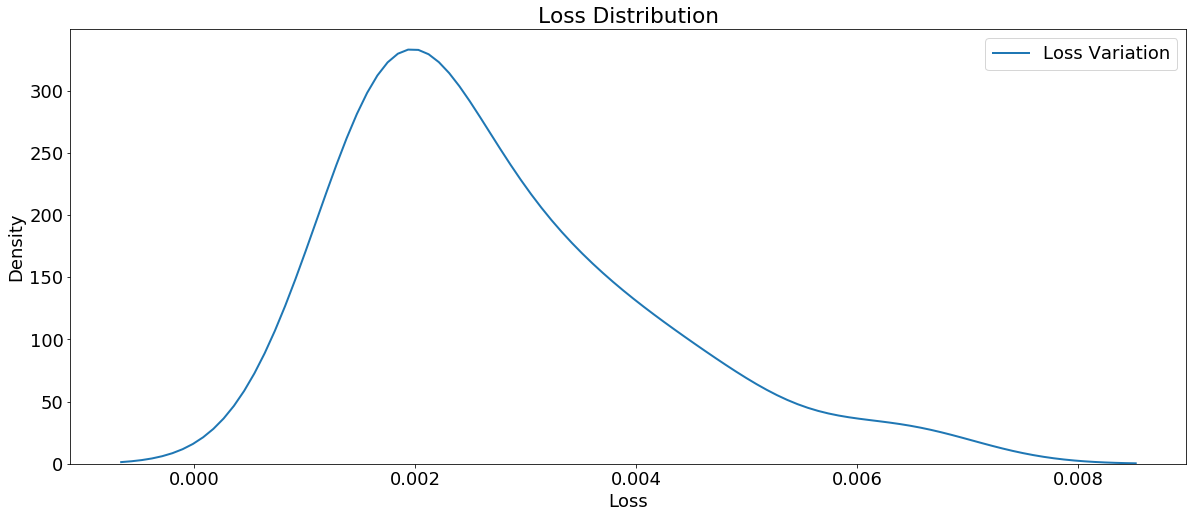

In [184]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


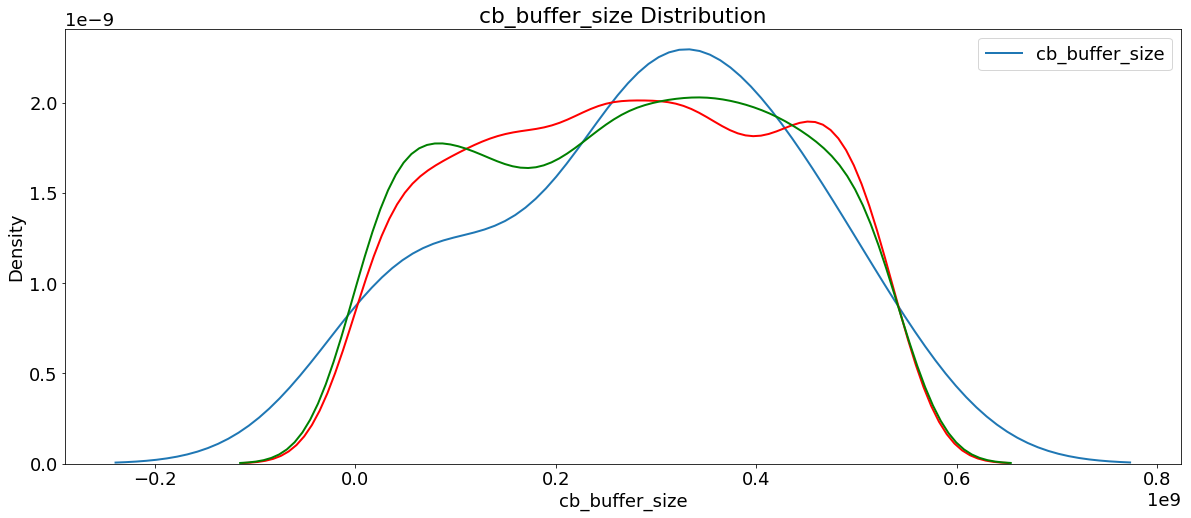

In [185]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
cb_buffer_size_dist_now = []
for _ in range(1000):
    cb_buffer_size_dist_now.append(sample(space)['cb_buffer_size'])
# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['cb_buffer_size'], label = 'cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2)
sns.kdeplot(cb_buffer_size_dist_now,color="green",linewidth=2)
plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');